In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np

In [ ]:
## sift code
import cv2
import numpy as np


def sift(img1, img2):
    """
    Computes point correspondences between two images using sift

    Args:
        img1 (np.array): Query image
        img2 (np.array): Target image

    Returns:
        points (np.array): A 2 X num_matches X 2 array.
                           `points[0]` are keypoints in img1 and the corresponding
                            keypoints in img2 are `points[1]`
    """
    sift = cv2.xfeatures2d.SIFT_create()

    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    correspondences = np.zeros((2, len(good_matches), 2))

    for i, match in enumerate(good_matches):
        correspondences[0, i, :] = np.flip(kp1[match.queryIdx].pt)
        correspondences[1, i, :] = np.flip(kp2[match.trainIdx].pt)

    return correspondences

In [ ]:
image1 = cv2.imread("img1.png")
image2 = cv2.imread("img2.png")
image3 = cv2.imread("img3.png")

In [ ]:
## getting the correspondence points
correspondence_12 = sift(image1, image2)
correspondence_32 = sift(image3, image2)
print(correspondence_12.shape)
print(correspondence_32.shape)

(2, 314, 2)
(2, 330, 2)


To find homography, we can solve this system of equations
$$
(x)h_1 + (y)h_2 + (1)h_3 + (0)h_4 + (0)h_5 + (0)h_6
- (x'x)h_7 - (x'y)h_8 - (x')h_9 = 0 \\
(0)h_1 + (0)h_2 + (0)h_3 + (x)h_4 + (y)h_5 + (1)h_6 - (y'x)h_7 - (y'y)h_8 - (y')h_9 = 0
$$

I am assuming $h_9$ to be one (i.e.,$h_9 = 1$ ) and rewriting the equations

$$
(x)h_1 + (y)h_2 + (1)h_3 + (0)h_4 + (0)h_5 + (0)h_6
- (x'x)h_7 - (x'y)h_8 = x' \\
(0)h_1 + (0)h_2 + (0)h_3 + (x)h_4 + (y)h_5 + (1)h_6 - (y'x)h_7 - (y'y)h_8 = y'
$$

After solving this system of equations for randomly choosen four points, we will check that if the distance of the transforming the other points is less than epsilon(here it is 10) and if the total points satisfying are more than 80% then we will take that homography and return that for the RANSAC algorithm.

In [ ]:
## we need to run the RANSAC algorithm
import random
def RANSAC(correspondence):
  # total no of points
  n = correspondence.shape[1]
  thresh = 0.8*n # That many points to be satisfied
  # it is mentioned 80% points should lie in the threshold
  max_points = 0
  max_H = np.zeros((3,3))
  iterations = 1000
  while (iterations > 0):
    # choose randomly four points
    random_points = random.sample(range(n), 4)
    iterations -= 1
    # here I am assuming h9 to be one
    Y = []
    A = []
    # need to solve for AX = Y


    for each in random_points:
      x = correspondence[0][each][0]
      y = correspondence[0][each][1]
      x_= correspondence[1][each][0]
      y_= correspondence[1][each][1]

      A.append([x, y, 1, 0, 0, 0, -1*x_*x, -1*x_*y])
      Y.append(x_)
      A.append([0, 0, 0, x, y, 1, -1*y_*x, -1*y_*y])
      Y.append(y_)

      X = np.zeros(8)

      try:
          # Attempt to solve the system assuming A is non-singular
          X = np.linalg.solve(A, Y)
      except np.linalg.LinAlgError:
          # If A is singular, compute the pseudoinverse of A and solve
          A_pinv = np.linalg.pinv(A)
          X = np.dot(A_pinv, Y)


    X = np.append(X, 1)
    # x vector is solution for the AX = Y
    H = X.reshape(3, 3)


    # now we got the Homography
    # we want to find the distance for the remaining points after
    # applying transformation
    cnt = 0
    for i in range(n):
      if i not in random_points:
        point = np.array([correspondence[0][i][0], correspondence[0][i][1], 1])
        new_point = np.dot(H, point)
        new_x = new_point[0]/new_point[2]
        new_y = new_point[1]/new_point[2]
        x_= correspondence[1][i][0]
        y_= correspondence[1][i][1]

        dis = (new_x - x_)**2 + (new_y - y_)**2
        if dis <= 10:
          cnt += 1

    if cnt > max_points:
      max_points = cnt
      max_H = H

    if cnt >= thresh:
      return H

  return max_H

In [ ]:
Homography_12 = RANSAC(correspondence_12)
Homography_32 = RANSAC(correspondence_32)

In [ ]:
print(Homography_12)
print(Homography_32)

[[ 1.26616420e+00  1.16117525e-01 -6.64768479e+01]
 [-2.32878257e-02  1.40961163e+00 -2.57400406e+02]
 [-2.62486624e-06  6.27836346e-04  1.00000000e+00]]
[[ 8.75649906e-01 -1.13451376e-01  3.61749210e+01]
 [ 7.20765963e-03  6.25384422e-01  2.57310176e+02]
 [-1.26077418e-05 -5.79815522e-04  1.00000000e+00]]


In [ ]:
np.linalg.inv(Homography_12)

array([[ 7.88396553e-01, -7.92071597e-02,  3.20221627e+01],
       [ 1.20242560e-02,  6.35241310e-01,  1.64310705e+02],
       [-5.47982946e-06, -3.99035490e-04,  8.96923821e-01]])

In [ ]:
import math
def transform_image(image, inverse_homography):
  rows = image.shape[0]
  cols = image.shape[1]
  channels = image.shape[2]

  transformed_image = np.zeros((rows, cols, channels))
  for i in range(rows):
    for j in range(cols):
      for c in range(channels):
        point = np.array([i, j, 1])
        new_point = np.dot(inverse_homography, point)
        source_x = new_point[0]/new_point[2]
        source_y = new_point[1]/new_point[2]

        floor_x = math.floor(source_x)
        floor_y = math.floor(source_y)

        # print(floor_x, floor_y)
        a = source_x - floor_x
        b = source_y - floor_y
        transformed_image[i][j][c] = 0  # Initialize with zero intensity

        if floor_x >= 0 and floor_x < rows and floor_y >= 0 and floor_y < cols:
            transformed_image[i][j][c] += (1 - a) * (1 - b) * image[floor_x][floor_y][c]
        if floor_x + 1 >= 0 and floor_x + 1 < rows and floor_y >= 0 and floor_y < cols:
            transformed_image[i][j][c] += a * (1 - b) * image[floor_x + 1][floor_y][c]
        if floor_x >= 0 and floor_x < rows and floor_y + 1 >= 0 and floor_y + 1 < cols:
            transformed_image[i][j][c] += (1 - a) * b * image[floor_x][floor_y + 1][c]
        if floor_x + 1 >= 0 and floor_x + 1 < rows and floor_y + 1 >= 0 and floor_y + 1 < cols:
            transformed_image[i][j][c] += a * b * image[floor_x + 1][floor_y + 1][c]

  return transformed_image

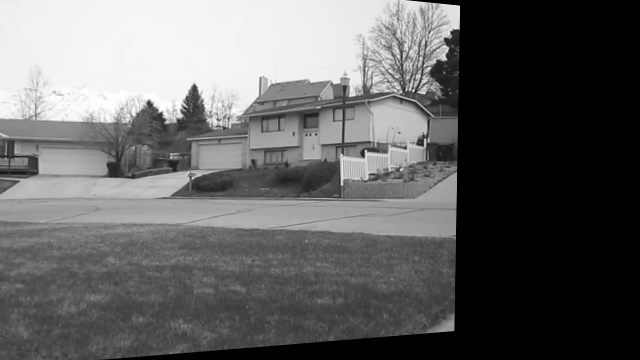

In [ ]:
transformed_image1 = transform_image(image1, np.linalg.inv(Homography_12))
cv2_imshow(transformed_image1)

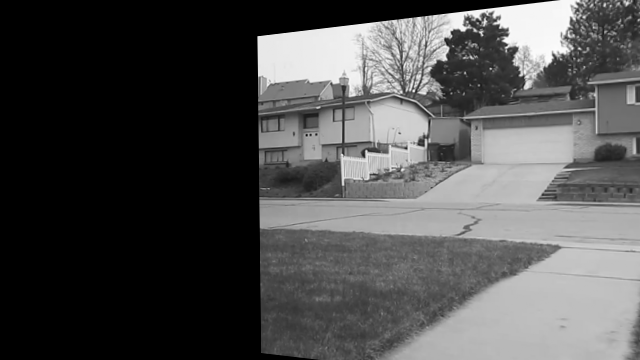

In [ ]:
transformed_image3 = transform_image(image3, np.linalg.inv(Homography_32))
cv2_imshow(transformed_image3)

In [ ]:
import math
def mosaicing(image1, image2, image3):
  # finding correspondence of images
  correspondence_12 = sift(image1, image2)
  correspondence_32 = sift(image3, image2)

  # finding homography using RANSAC
  Homography_12 = RANSAC(correspondence_12)
  Homography_32 = RANSAC(correspondence_32)

  # finding inverse of the homography
  inv_homog_12 = np.linalg.inv(Homography_12)
  inv_homog_32 = np.linalg.inv(Homography_32)

  # creating canvas and combining them
  canvas = np.zeros((image3.shape[0]*3, image3.shape[1]*3, image3.shape[2]))
  # for making the image2 at the center
  offset_x = image2.shape[0]
  offset_y = image2.shape[1]

  rows = image2.shape[0]
  cols = image2.shape[1]

  # Image 2 is the base image so it will be centered first
  for i in range(rows):
    for j in range(cols):
      canvas[offset_x+i][offset_y+j] = image2[i][j]

  inv_homog_12 = np.linalg.inv(Homography_12)
  inv_homog_32 = np.linalg.inv(Homography_32)

  for i in range(3*rows):
    for j in range(3*cols):
      point = np.array([i-offset_x, j-offset_y, 1])
      new_point = np.dot(inv_homog_12, point)
      source1_x = new_point[0]/new_point[2]
      source_y = new_point[1]/new_point[2]

      floor_x = math.floor(source1_x)
      floor_y = math.floor(source_y)

      # print(floor_x, floor_y)
      a = source1_x - floor_x
      b = source_y - floor_y
      temp = 0  # Initialize with zero intensity

      if floor_x >= 0 and floor_x < rows and floor_y >= 0 and floor_y < cols:
          temp += (1 - a) * (1 - b) * image1[floor_x][floor_y]
      if floor_x + 1 >= 0 and floor_x + 1 < rows and floor_y >= 0 and floor_y < cols:
          temp += a * (1 - b) * image1[floor_x + 1][floor_y]
      if floor_x >= 0 and floor_x < rows and floor_y + 1 >= 0 and floor_y + 1 < cols:
          temp += (1 - a) * b * image1[floor_x][floor_y + 1]
      if floor_x + 1 >= 0 and floor_x + 1 < rows and floor_y + 1 >= 0 and floor_y + 1 < cols:
          temp += a * b * image1[floor_x + 1][floor_y + 1]

      if (canvas[i][j] == 0).all():
          if np.any(temp != 0):
              canvas[i][j] = temp
      else:
          if np.any(temp != 0):
            canvas[i][j] = (canvas[i][j] + temp)/2

      point = np.array([i-offset_x, j-offset_y, 1])
      new_point = np.dot(inv_homog_32, point)
      source2_x = new_point[0]/new_point[2]
      source2_y = new_point[1]/new_point[2]

      floor2_x = math.floor(source2_x)
      floor2_y = math.floor(source2_y)

      # print(floor_x, floor_y)
      a = source2_x - floor2_x
      b = source2_y - floor2_y
      temp = 0  # Initialize with zero intensity

      if floor2_x >= 0 and floor2_x < rows and floor2_y >= 0 and floor2_y < cols:
          temp += (1 - a) * (1 - b) * image3[floor2_x][floor2_y]
      if floor2_x + 1 >= 0 and floor2_x + 1 < rows and floor2_y >= 0 and floor2_y < cols:
          temp += a * (1 - b) * image3[floor2_x + 1][floor2_y]
      if floor2_x >= 0 and floor2_x < rows and floor2_y + 1 >= 0 and floor2_y + 1 < cols:
          temp += (1 - a) * b * image3[floor2_x][floor2_y + 1]
      if floor2_x + 1 >= 0 and floor2_x + 1 < rows and floor2_y + 1 >= 0 and floor2_y + 1 < cols:
          temp += a * b * image3[floor2_x + 1][floor2_y + 1]

      if (canvas[i][j] == 0).all():
          if np.any(temp != 0):
              canvas[i][j] = temp
      else:
          if np.any(temp != 0):
            canvas[i][j] = (canvas[i][j] + temp)/2

  # the final
  return canvas

In [ ]:
image1 = cv2.imread("img1.png")
image2 = cv2.imread("img2.png")
image3 = cv2.imread("img3.png")

mosaiced_image = mosaicing(image1, image2, image3)

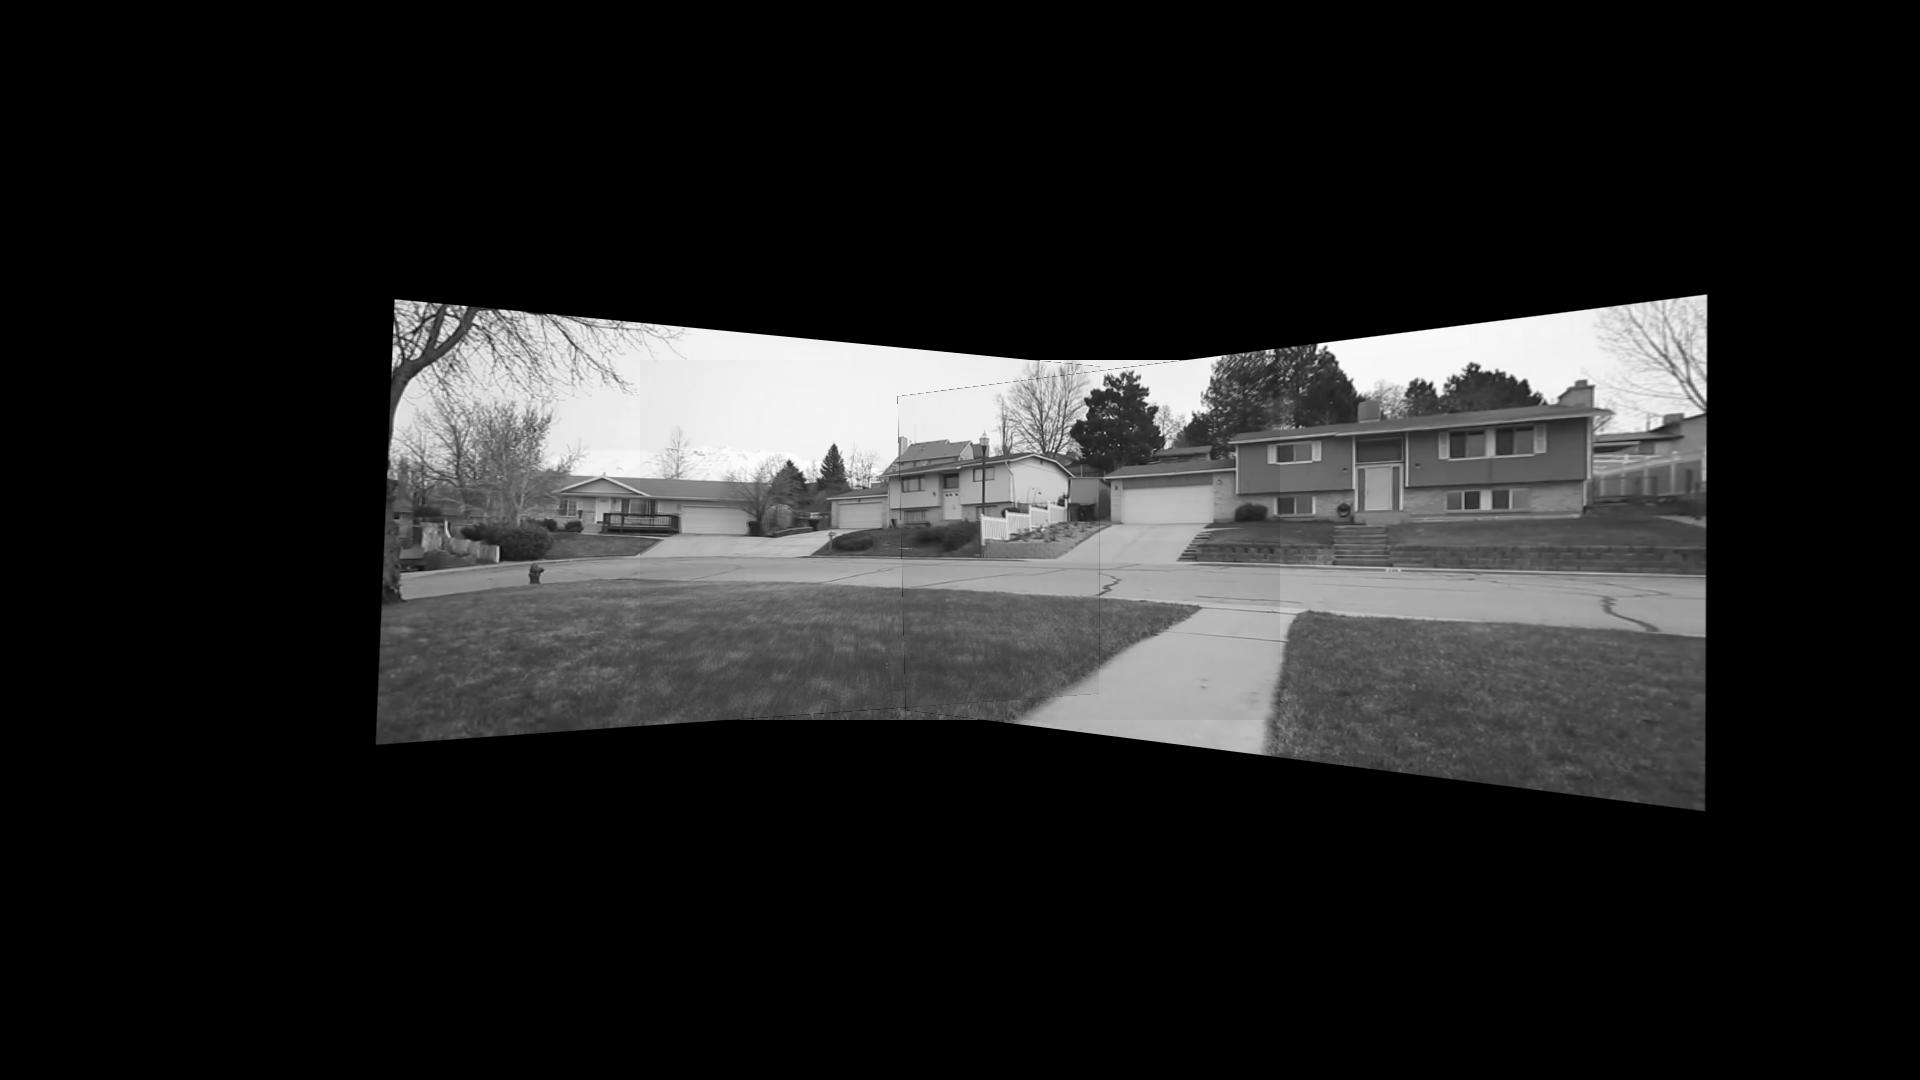

In [ ]:
cv2_imshow(mosaiced_image)

For new input data trying mosaicing

* Mandakini Hostel
* Gagendra Circle

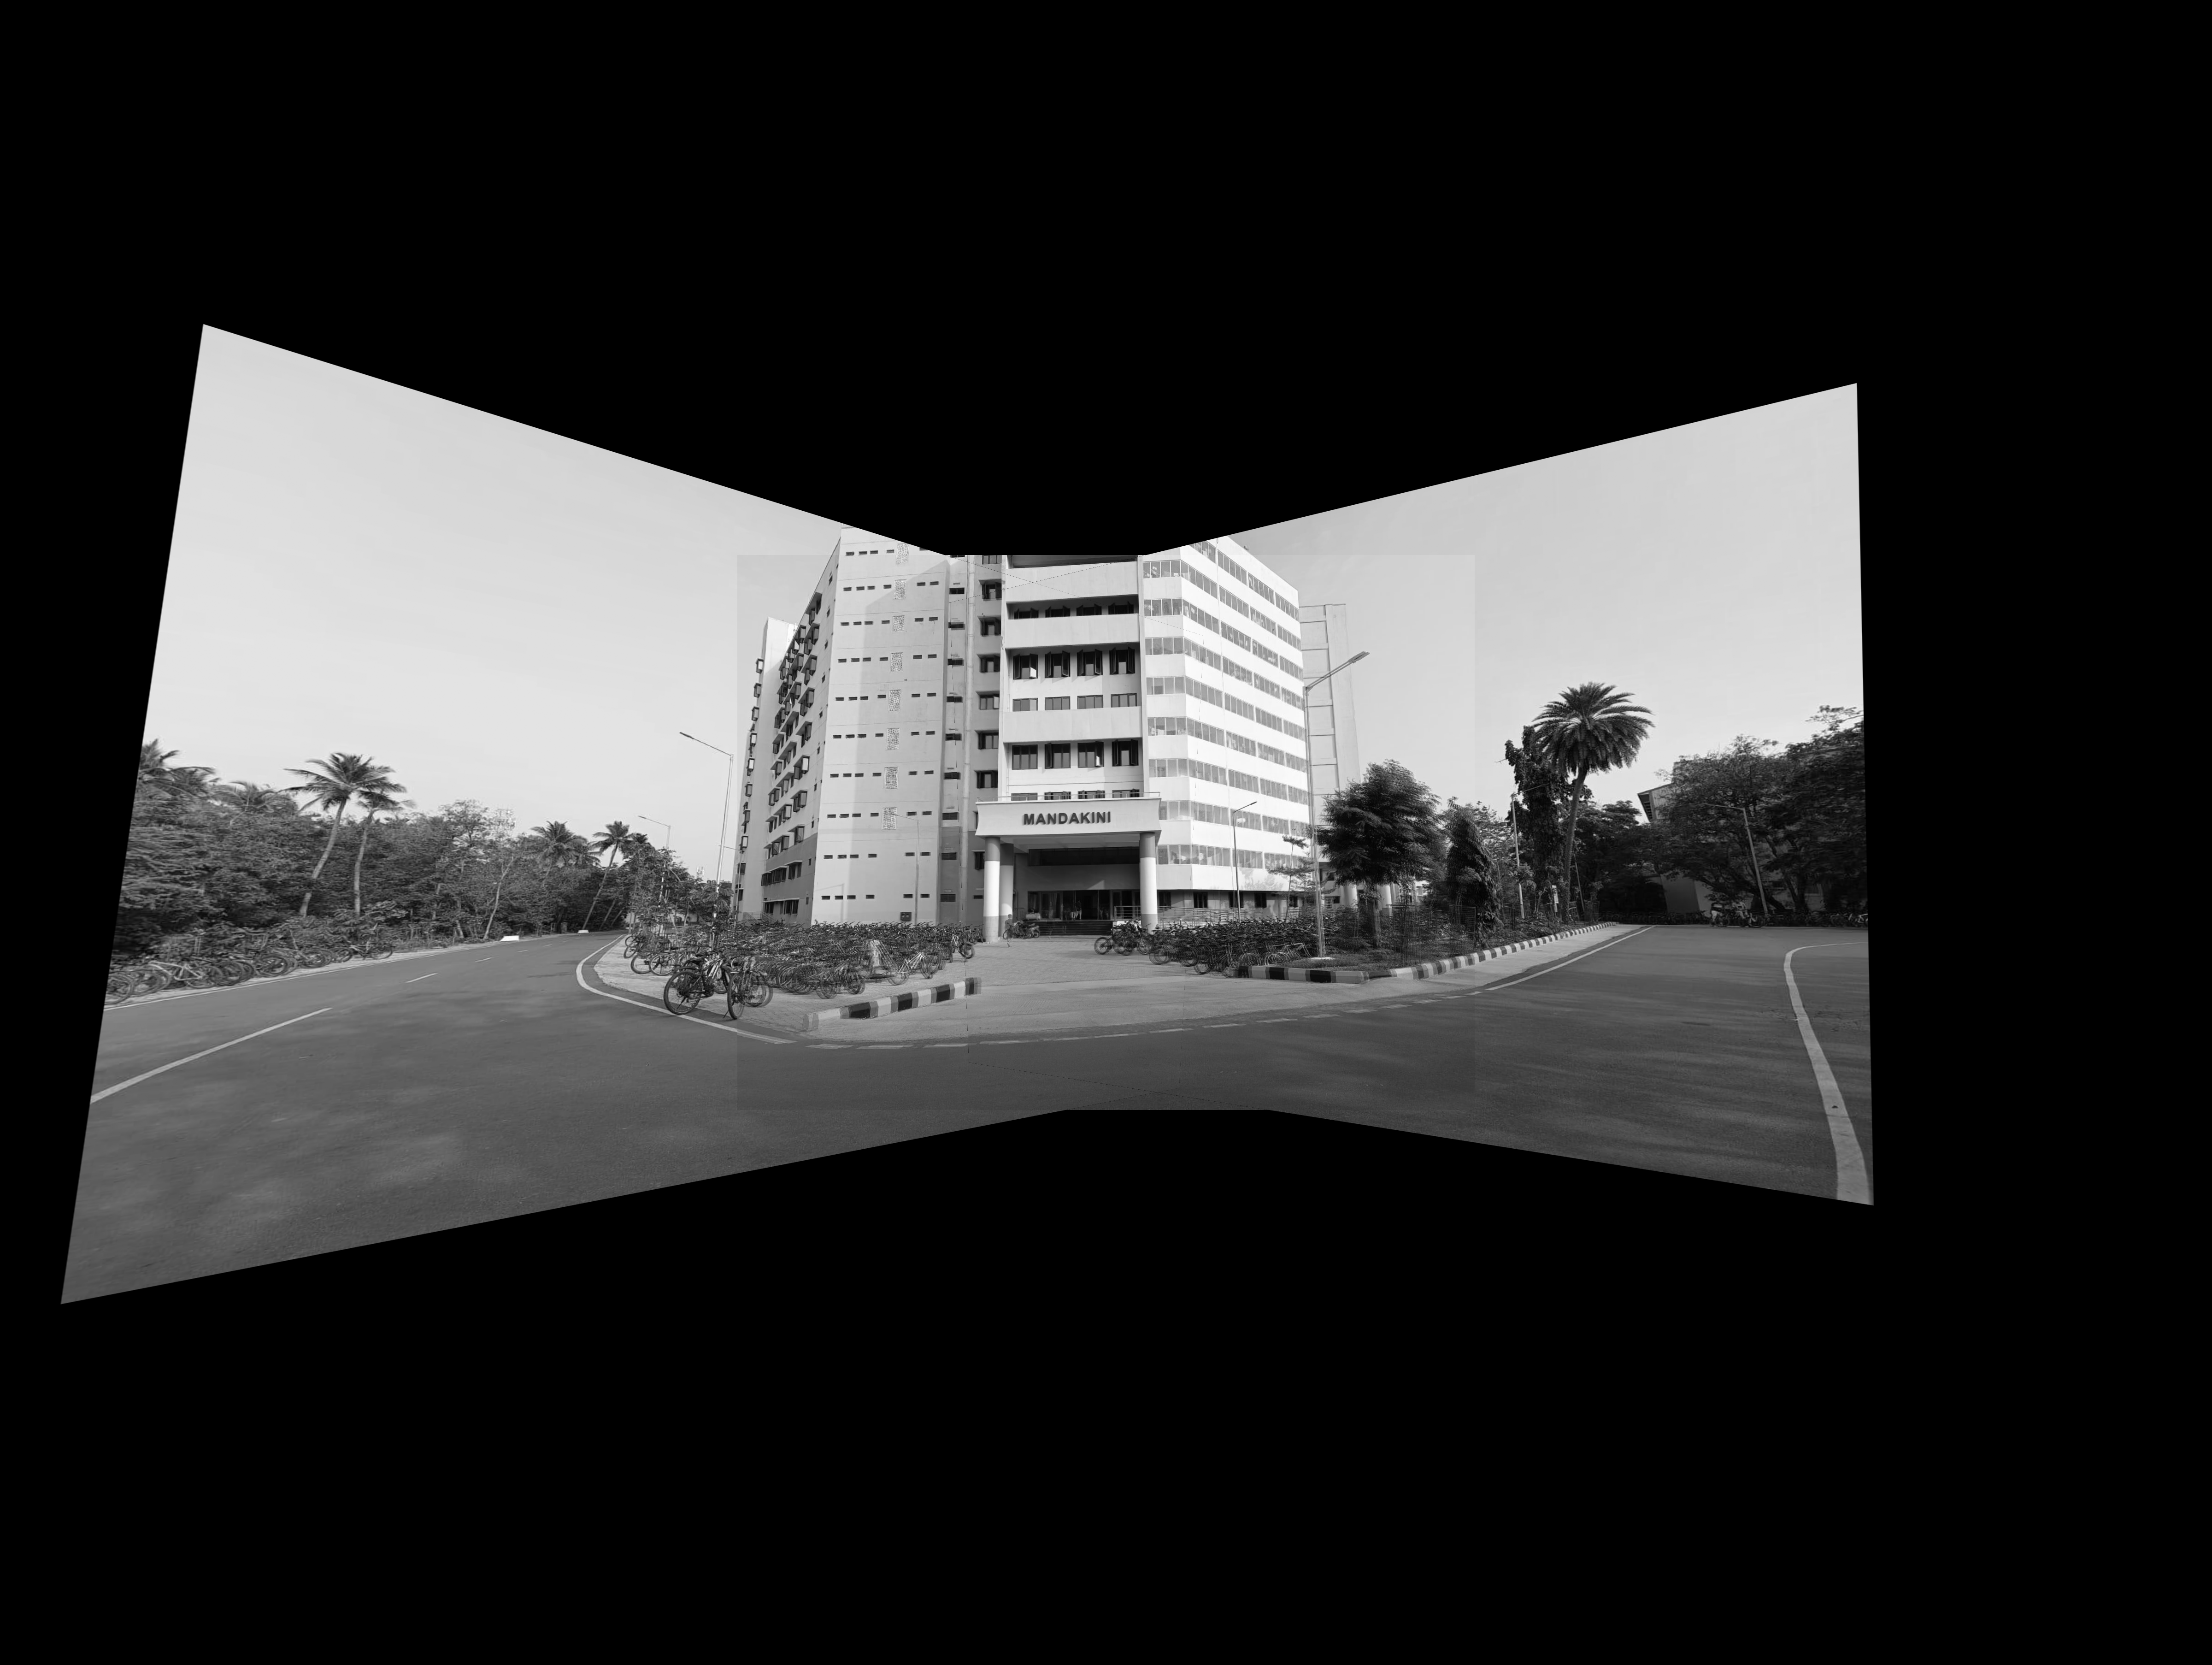

In [ ]:
# Mandaikini Hostel
image1 = cv2.imread("mandakini_1.jpg")
image2 = cv2.imread("mandakini_2.jpg")
image3 = cv2.imread("mandakini_3.jpg")

mosaiced_image = mosaicing(image1, image2, image3)
cv2_imshow(mosaiced_image)

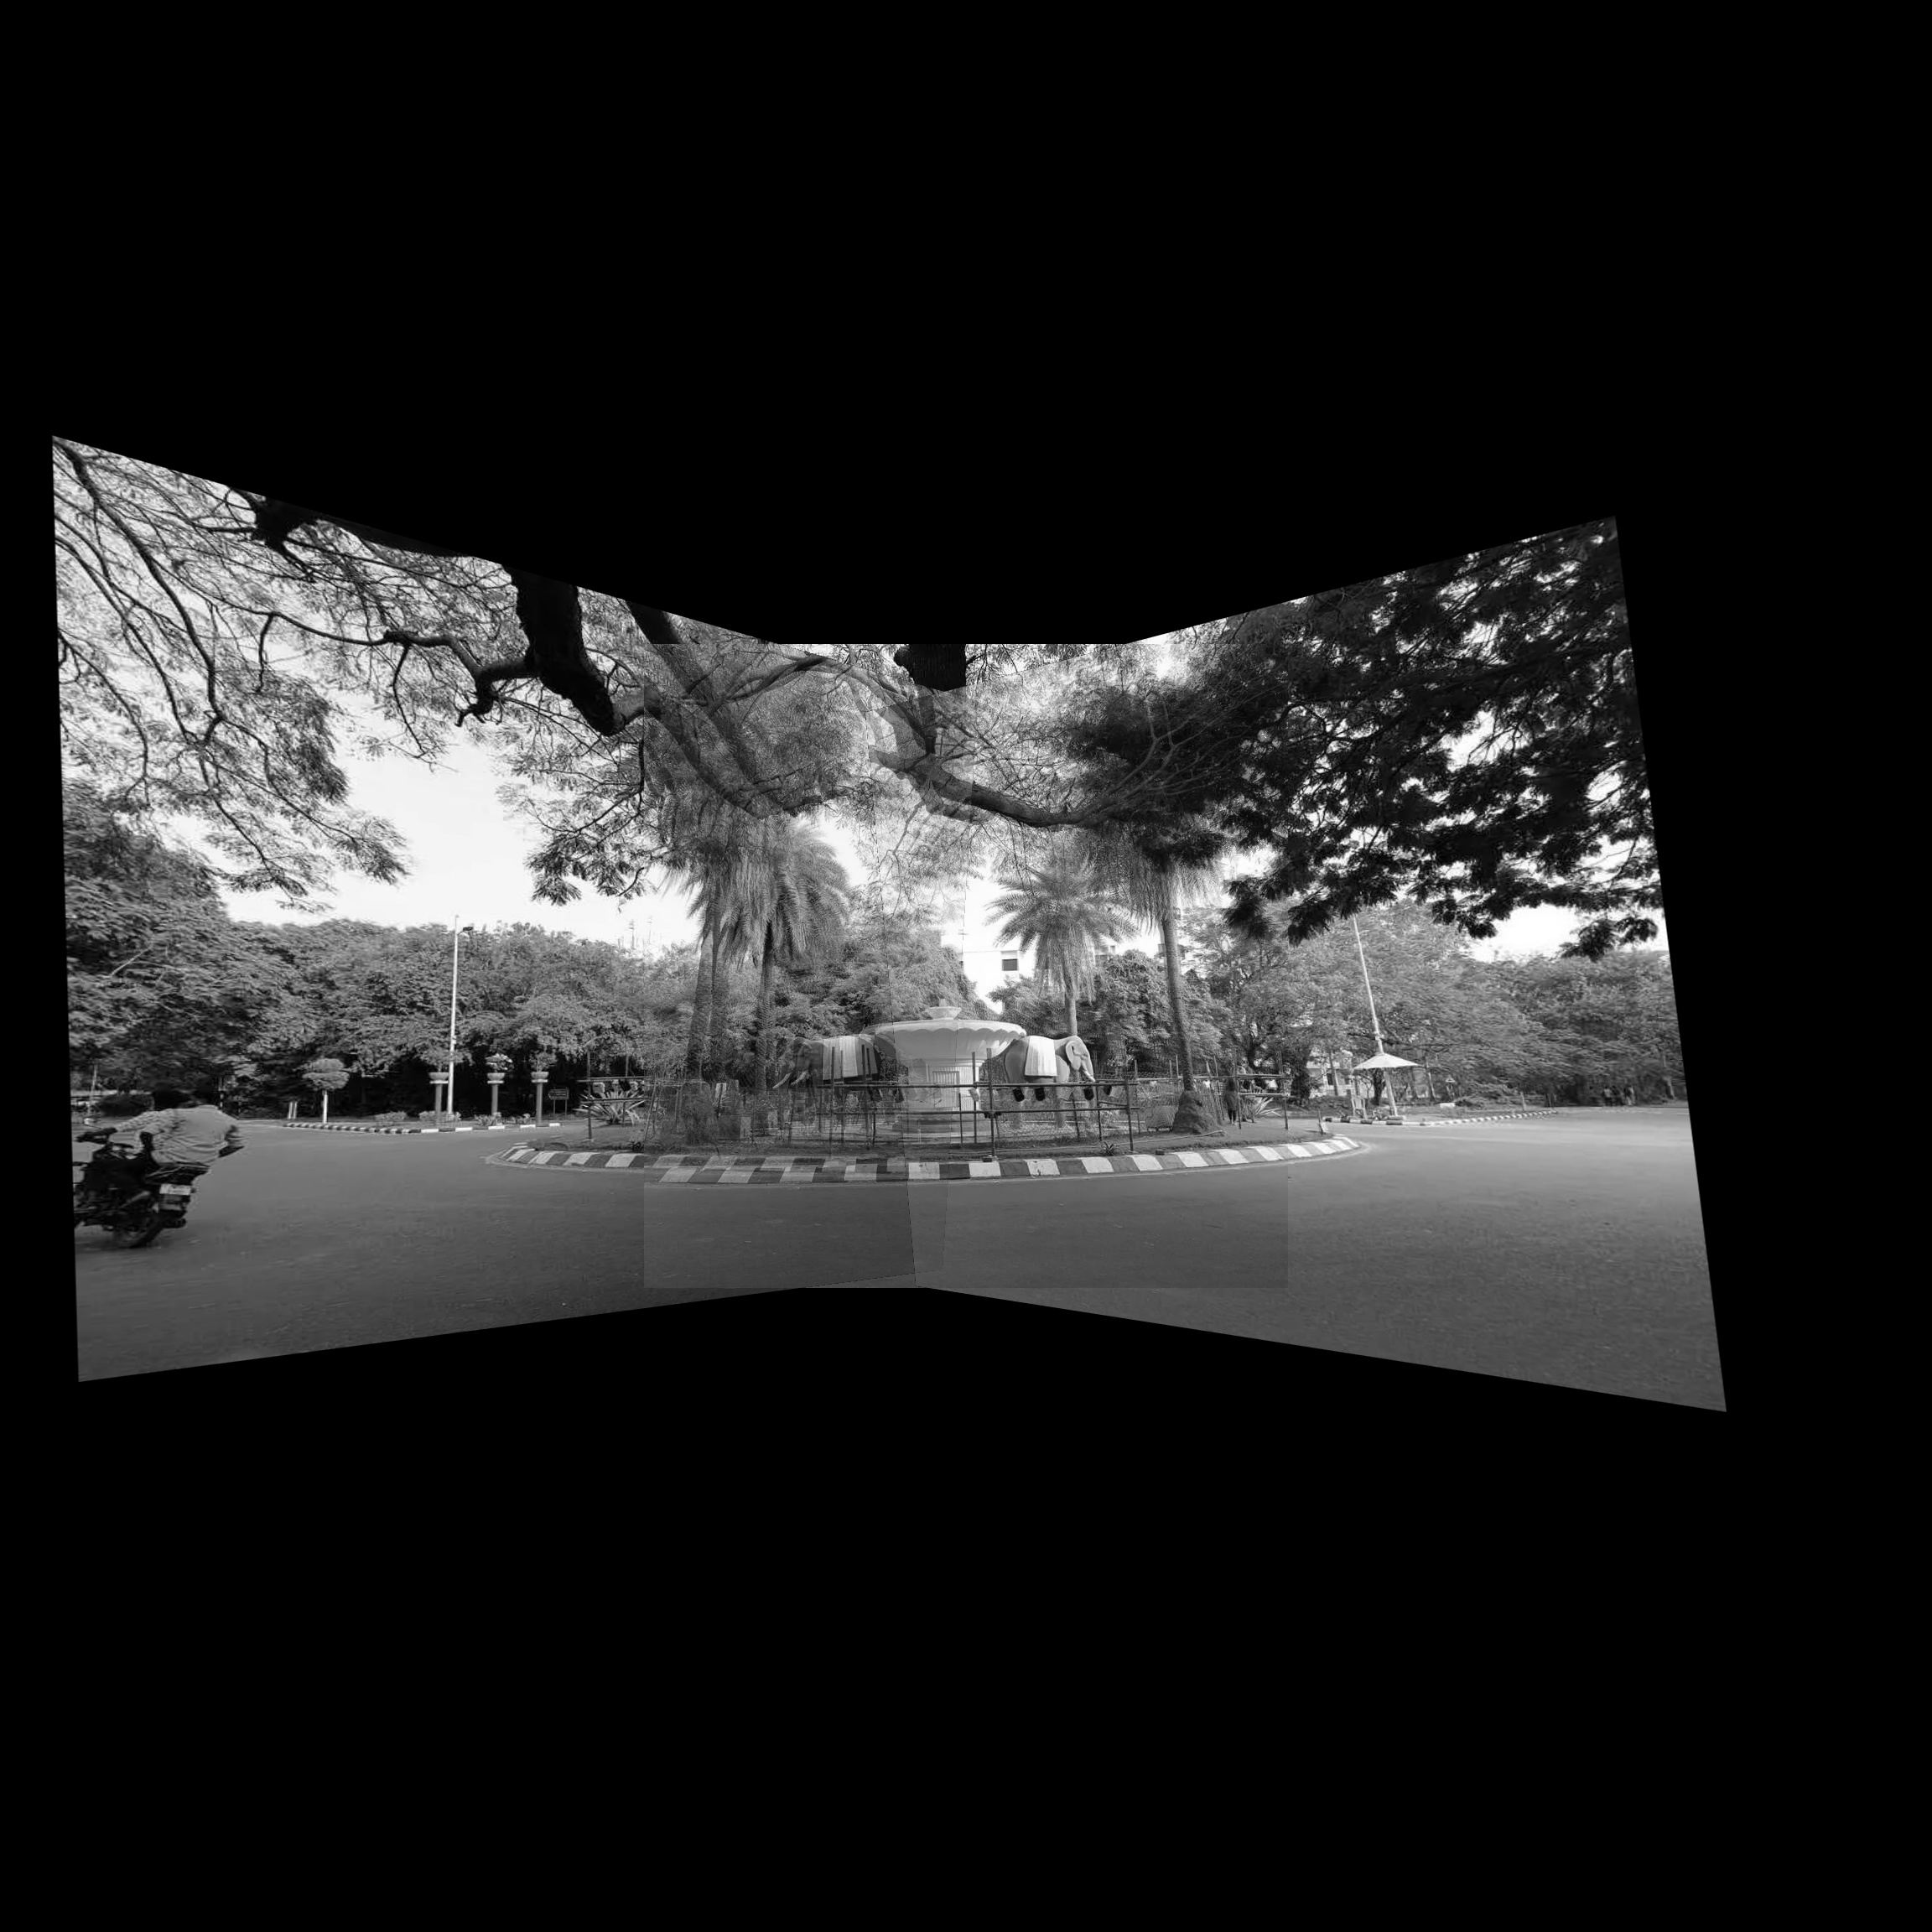

In [ ]:
ggc1 = cv2.imread("ggc_1.jpg")
ggc2 = cv2.imread("ggc_2.jpg")
ggc3 = cv2.imread("ggc_3.jpg")

mosaiced_image = mosaicing(ggc1, ggc2, ggc3)
cv2_imshow(mosaiced_image)

## (Extra) Checking the correspondence

Checking how the sift correspondence of images

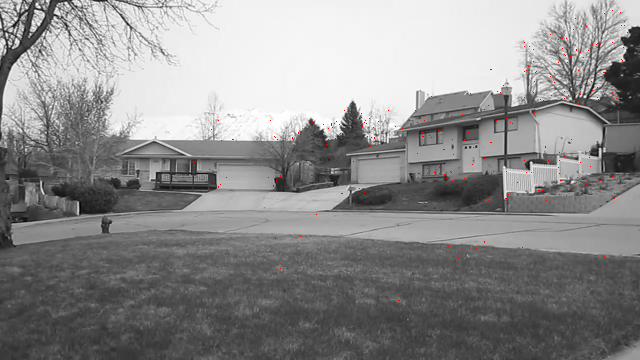

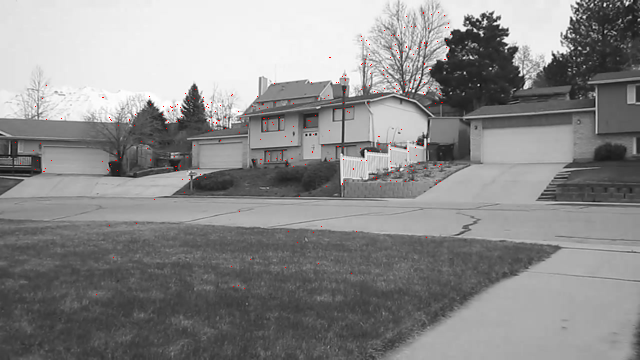

In [ ]:
## just checking how the correspondence looks like
import math
temp = image1
for each in correspondence_12[0]:
  x = math.ceil(each[0])
  y = math.ceil(each[1])
  temp[x][y][0] = 0
  temp[x][y][1] = 0
  temp[x][y][2] = 255

cv2_imshow(temp)
temp = image2
for each in correspondence_12[1]:
  x = math.ceil(each[0])
  y = math.ceil(each[1])
  temp[x][y][0] = 0
  temp[x][y][1] = 0
  temp[x][y][2] = 255

cv2_imshow(temp)